# Age Prediction based on segmented knee MRIs

This notebook contains a preliminary proof of concept regarding my bachelor thesis **Automated Segmentation of Bones for the Age Assessment in 3D MR Images using Convolutional Neural Networks**. I train a CNN to predict the age of a 14-21 year old male individual based on their knee MRI.

## 1 Imports

In [1]:
from utils import *
%matplotlib inline

Using TensorFlow backend.


## 2 Data Preprocessing

Load the data while applying cropping and resizing

In [ ]:
x_jop,y_jop = load_data_age('data/Jopp_Study/MHD/*.mhd',crop=[128,128,256],size=(224,224),smart_crop=True,bias=True)
x_epi,y_epi = load_data_age('data/Epi_Study/MHD/*.mhd',crop=[120,120,560],size=(224,224),smart_crop=False,bias=True)

In [ ]:
np.savez('data/data_age', x_epi=x_epi, y_epi=y_epi, x_jop=x_jop, y_jop=y_jop)

In [2]:
x_jop = np.load('data/data_age.npz')['x_jop']
y_jop = np.load('data/data_age.npz')['y_jop']
x_epi = np.load('data/data_age.npz')['x_epi']
y_epi = np.load('data/data_age.npz')['y_epi']

The first and last slices on the z-axis show no bone matter and are therefor left empty after the segmentation is applied. I remove them here to get them out the way and also bring both data sources to the same z-axis resolution of 18 slices.

Note: The segmentation network is trained on all slices.

In [3]:
x_jop = x_jop[:, 4:-2]
x_epi = x_epi[:, 12:-11]

Create Train, Validation and Test set and convert data to 2D. 

- 2124 (118x18) samples in the training set
- 234 (13x18) samples in the validation set
- 252 (14x18) samples in the test set

In [4]:
for i in range(len(x_jop)):
    x_jop[i] = (x_jop[i] - x_jop[i].mean()) / x_jop[i].std()
for i in range(len(x_epi)):
    x_epi[i] = (x_epi[i] - x_epi[i].mean()) / x_epi[i].std()

In [5]:
x_tr_raw = np.concatenate((to_2d(x_epi[:54]), to_2d(x_jop[:64])))
y_tr = np.concatenate((lengthen(y_epi[:54], 18), lengthen(y_jop[:64], 18)))
x_va_raw = np.concatenate((to_2d(x_epi[54:59]), to_2d(x_jop[64:72])))
y_va = np.concatenate((lengthen(y_epi[54:59], 18), lengthen(y_jop[64:72], 18)))
x_te_raw = np.concatenate((to_2d(x_epi[59:]), to_2d(x_jop[72:])))
y_te = np.concatenate((lengthen(y_epi[59:], 18), lengthen(y_jop[72:], 18)))

Load the pretrained segmentation model and predict maps for the entire data

In [6]:
model = UNet(x_tr_raw.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.load_weights('weights/seg_merged.h5')
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)

In [7]:
x_tr_mask = model.predict(x_tr_raw, batch_size=8, verbose=1)
x_va_mask = model.predict(x_va_raw, batch_size=8, verbose=1)
x_te_mask = model.predict(x_te_raw, batch_size=8, verbose=1)

252/252 [==============================] - 34s    


Check a few samples of the data if everything seems right

In [8]:
x_tr_mask = erode(x_tr_mask, 7)
x_va_mask = erode(x_va_mask, 7)
x_te_mask = erode(x_te_mask, 7)

Let's take a look at the labels.

In [9]:
print('Oldest candidate:', round(y_tr.max(),1))
print('Youngest candidate:', round(y_tr.min(),1))
print('Age range:', round(y_tr.max()-y_tr.min(),1))
print('Average age:', round(y_tr.mean(),1))
print('Baseline:', round(abs(y_tr.mean()-y_tr).mean(),1))

Oldest candidate: 20.9
Youngest candidate: 14.4
Age range: 6.5
Average age: 17.4
Baseline: 1.2


In [10]:
x_tr = x_tr_raw * x_tr_mask
x_va = x_va_raw * x_va_mask
x_te = x_te_raw * x_te_mask

Augment the training data using horizontal flips and horizontal shift at 20px. This will virtually increase the training data by a factor of 6.

In [11]:
#x_tr, y_tr_cls = augment(x_tr, y_tr, h_flip=True, edge_mode='edge')

In [12]:
#y_tr = lengthen(y_tr, 2)

Let's look at the samples one more time with the segmentation mask applied.

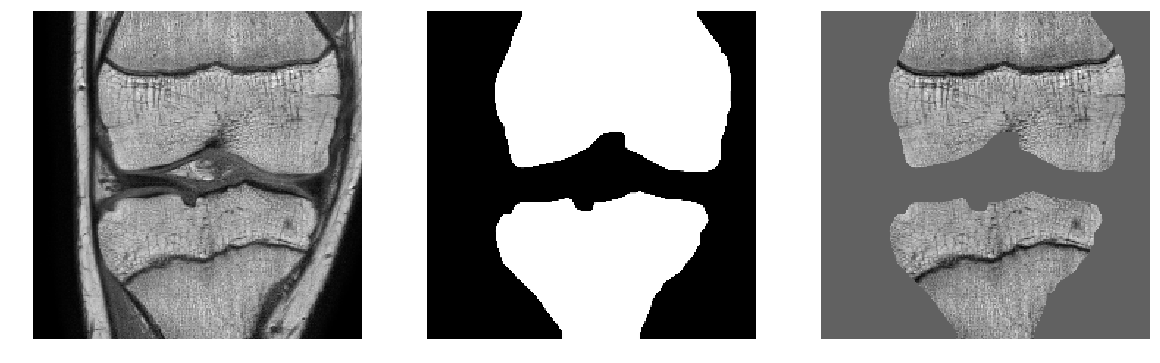

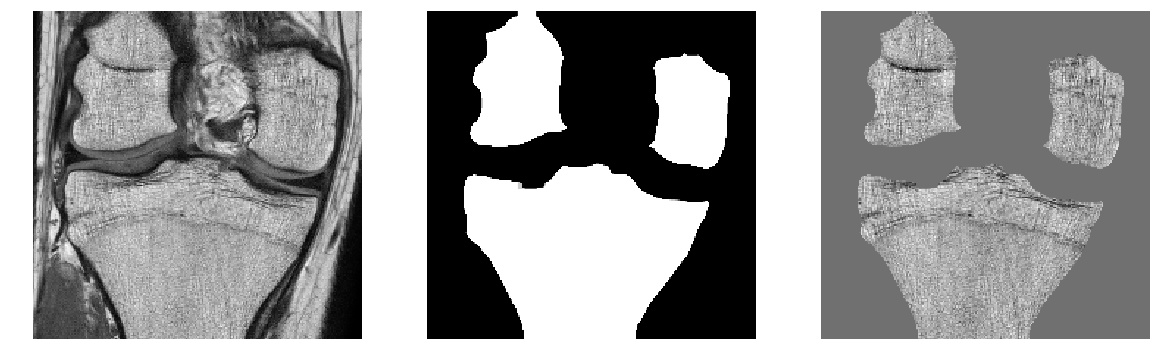

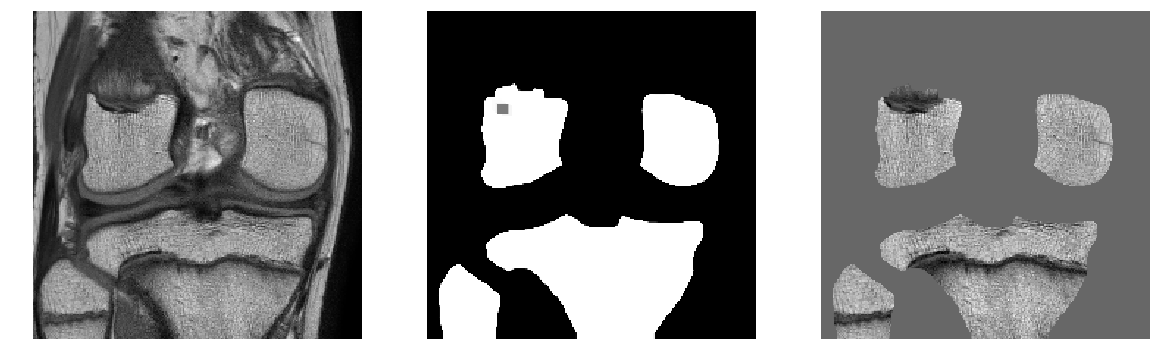

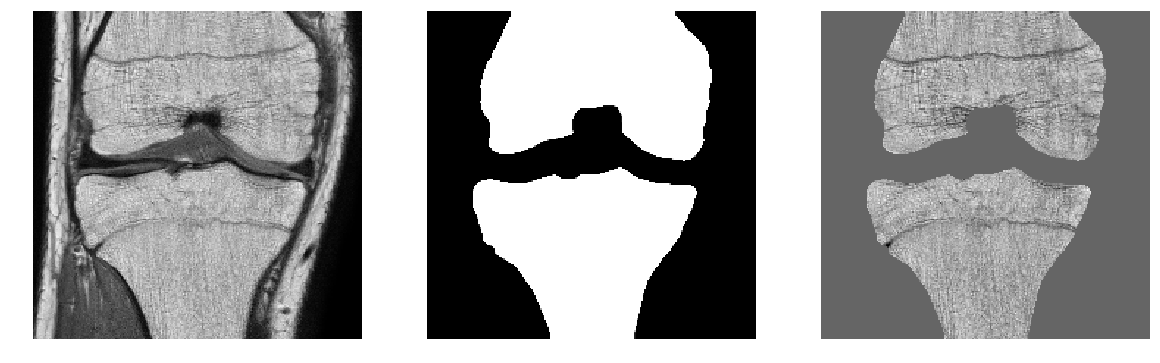

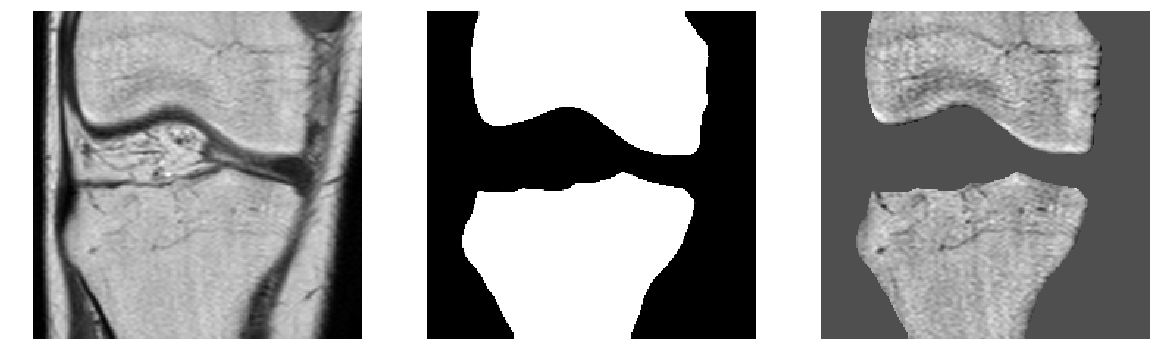

In [13]:
show_samples_2d([x_tr_raw, x_tr_mask, x_tr], 5)

In [15]:
print(x_tr.shape, y_tr.shape)

(2124, 224, 224, 1) (2124,)


## 3 Training

The segmentation model from above uses a encoder-decoder architecture, which will first reduce the spatial resolution of inputs similar to common classification networks. Then on the second half expand the resolution again to create a full segmentation map.

How about we use the first half of that architecture as a pre-trained model for the age prediction? Delete the decoding layers and append 2 new ones for the regression output.

In [ ]:
model = UNet(x_tr.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.load_weights('weights/seg_merged.h5')

In [ ]:
del model.layers[-17:]
x = model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)
model = Model(inputs=model.input, outputs=x)

In [ ]:
model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.fit(x_tr, y_tr, validation_data=(x_va, y_va), epochs=3, batch_size=64)

## 4 Validation

In [16]:
model = UNet(x_tr.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
del model.layers[-17:]
x = model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)
model = Model(inputs=model.input, outputs=x)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])

In [17]:
model.load_weights('weights/age.h5')

In [30]:
y_tr_pred = model.predict(x_tr, verbose=1)
y_va_pred = model.predict(x_va, verbose=1)

234/234 [==============================] - 11s    


In [31]:
y_tr_pred = y_tr_pred.sum(axis=-1)
y_va_pred = y_va_pred.sum(axis=-1)

Let's look at the mean difference and standard deviation 

In [32]:
print(abs(y_tr - y_tr_pred).mean())
print(abs(y_tr - y_tr_pred).std())

0.712145687571
0.582219063059


In [33]:
print(abs(y_va - y_va_pred).mean())
print(abs(y_va - y_va_pred).std())

0.639984095538
0.4833797252


In [34]:
age_vec_pred_tr = np.reshape(y_tr_pred, (len(y_tr_pred) // 18, 18))
age_vec_pred_va = np.reshape(y_va_pred, (len(y_va_pred) // 18, 18))

In [35]:
age_tr = np.reshape(y_tr, (len(y_tr) // 18, 18))
age_va = np.reshape(y_va, (len(y_va) // 18, 18))

In [36]:
prob_vec_va = abs(age_va - age_vec_pred_va).mean(axis=0)

<Container object of 18 artists>

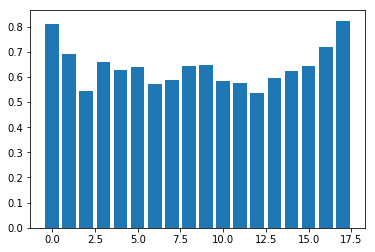

In [37]:
plt.bar(range(18), prob_vec_va)

This graph shows the mean difference for each slice going from the top to the bottom.

In [38]:
age_tr = shorten(y_tr, 18)
age_va = shorten(y_va, 18)

In [40]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
reg = ExtraTreesRegressor(max_depth=3)
reg.fit(age_vec_pred_tr, age_tr)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=3,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [42]:
from sklearn.externals import joblib
reg = joblib.load('weights/vec_etr.pkl') 

In [43]:
age_pred_tr = reg.predict(age_vec_pred_tr)
age_pred_va = reg.predict(age_vec_pred_va)

In [44]:
print(abs(age_tr - age_pred_tr).mean())
print(abs(age_tr - age_pred_tr).std())

0.45699032254
0.347454764364


In [45]:
print(abs(age_va - age_pred_va).mean())
print(abs(age_va - age_pred_va).std())

0.560296180122
0.403735807116


## 6 Final Verification

Let's do all of this for the test set and verify the performance

In [46]:
y_te_pred_reg = model.predict(x_te, verbose=1)
y_te_pred_reg = y_te_pred_reg.sum(axis=-1)
print(' - ')
print('Vec Mean ' + str(abs(y_te - y_te_pred_reg).mean()))
age_vec_pred_te_reg = np.reshape(y_te_pred_reg, (len(y_te_pred_reg) // 18, 18))
age_te = shorten(y_te, 18)

age_pred_te = reg.predict(age_vec_pred_te_reg)
print(' - ')
print('Mean ' + str(abs(age_te - age_pred_te).mean()))
print('Std  ' + str(abs(age_te - age_pred_te).std()))
print('Min  ' + str(abs(age_te - age_pred_te).min()))
print('Max  ' + str(abs(age_te - age_pred_te).max()))

252/252 [==============================] - 12s    
 - 
Vec Mean 0.73101962685
 - 
Mean 0.484716052419
Std  0.317834441707
Min  0.0742235705471
Max  1.36835769819
